**Overview**

Build a concise, production-ready breast cancer prediction workflow using a 3-feature model. 
This notebook clarifies each step with titled blocks, explanations, and visuals, then exports a lightweight 
model + scaler and a ready-to-deploy Gradio app for Hugging Face Spaces.

**Objectives**
- Build a classification model to predict tumor type (benign or malignant).
- Evaluate model performance using appropriate metrics.
- Interpret model results to identify key diagnostic features.

---

- **Environment Setup**
    - Import libraries: pandas, numpy, matplotlib, seaborn, sklearn
    - Set plotting styles and random seed

In [1]:
# Import libraries: pandas, numpy, matplotlib, seaborn, sklearn
import pandas as pd
import numpy as np
import gradio as gr
import seaborn as sns
%pip install shape -q
%pip install gradio -q
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
%pip install matplotlib seaborn scikit-learn pandas numpy -q
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set plotting styles and random seed
# Set plotting style
sns.set_style("whitegrid")

# Set a random seed for reproducibility
np.random.seed(42)

- **Data Loading**
    - Load the dataset (CSV or via sklearn.datasets)
    - Preview data: df.head(), df.info(), df.describe()


In [3]:
# Load the dataset (CSV)
df = pd.read_csv('data.csv')  # update with your CSV path
# Encode target
df["diagnosis"] = df["diagnosis"].map({"M":1, "B":0})

In [4]:
# Review data: df.head(), df.info(), df.describe()
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Review df.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
# Review df.describe()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


- **Data Cleaning**
    - Check for missing values
    - Convert diagnosis labels to binary (e.g., M = 1, B = 0)
    - Drop irrelevant columns (e.g., ID)

In [7]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [8]:
# Convert diagnosis labels to binary (e.g., M = 1, B = 0)
from sklearn.preprocessing import LabelEncoder

# Convert diagnosis labels to binary (M = 1, B = 0)
labelencoder = LabelEncoder()
df['diagnosis'] = labelencoder.fit_transform(df['diagnosis'])

print("Diagnosis labels converted to binary:")
print(df['diagnosis'].value_counts())

Diagnosis labels converted to binary:
diagnosis
0    357
1    212
Name: count, dtype: int64


In [9]:
# Drop irrelevant columns (e.g., ID)
# Drop irrelevant columns (e.g., ID)
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("'id' column dropped.")
else:
    print("'id' column not found.")

'id' column dropped.


In [10]:
features = ["perimeter_worst", "concave_points_worst", "radius_worst"]
X = df[features]
y = df["diagnosis"]

- **Handle class imbalance**

In [11]:
# Traub/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
smote = SMOTE(random_state=101)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

> **What this does:** Execute the following step in the workflow.


- **Feature Engineering & Scaling**

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

> **What this does:** Transform features (e.g., scaling/encoding) so models learn effectively.


- **Exploratory Data Analysis (EDA)**
    - Distribution of diagnosis labels
    - Correlation heatmap of features
    - Boxplots or violin plots for key features
    - Insights on feature importance


========== Distribution of perimeter_worst ==========



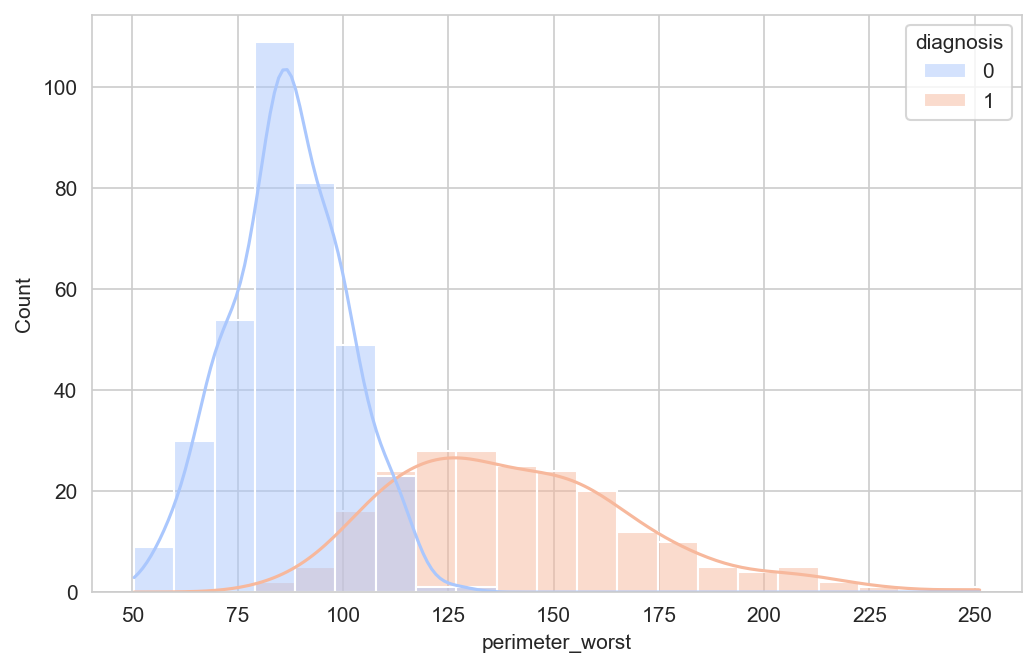


========== Distribution of concave_points_worst ==========



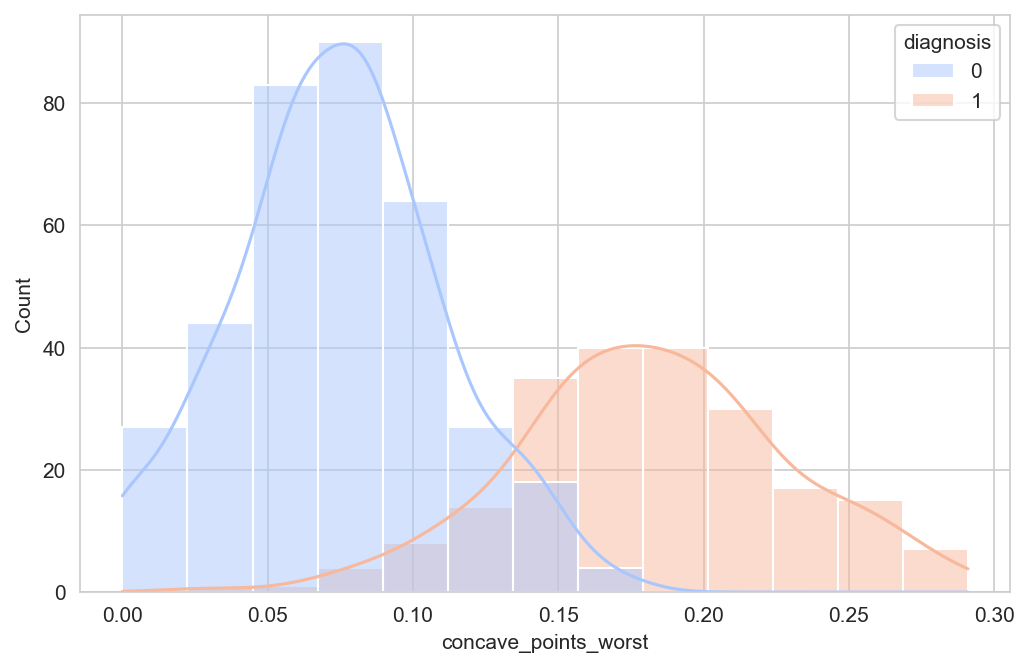


========== Distribution of radius_worst ==========



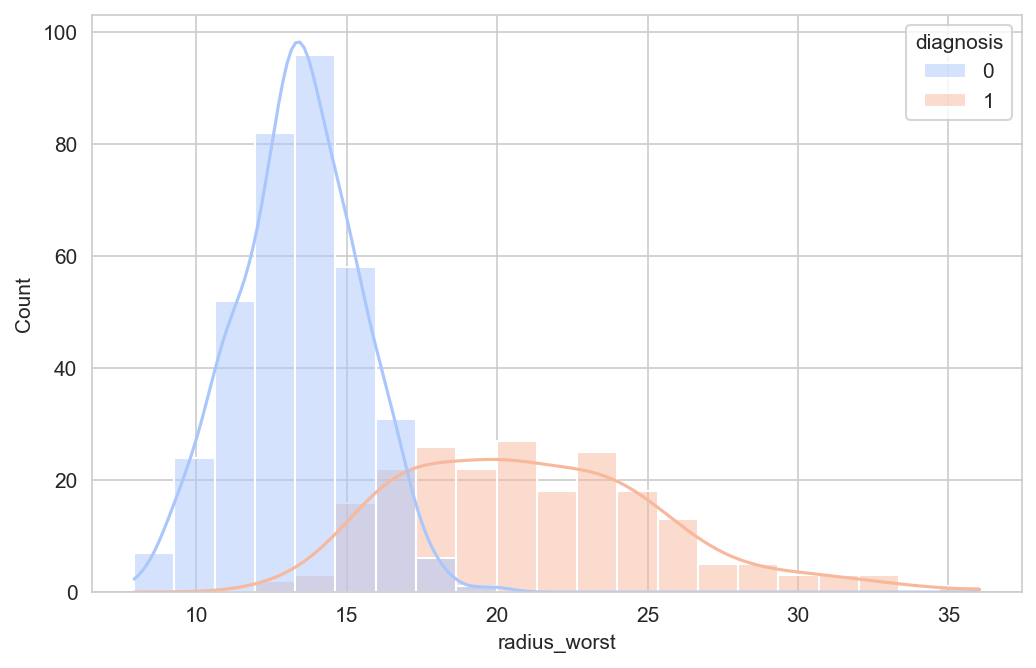


========== Distribution of Diagnosis ==========



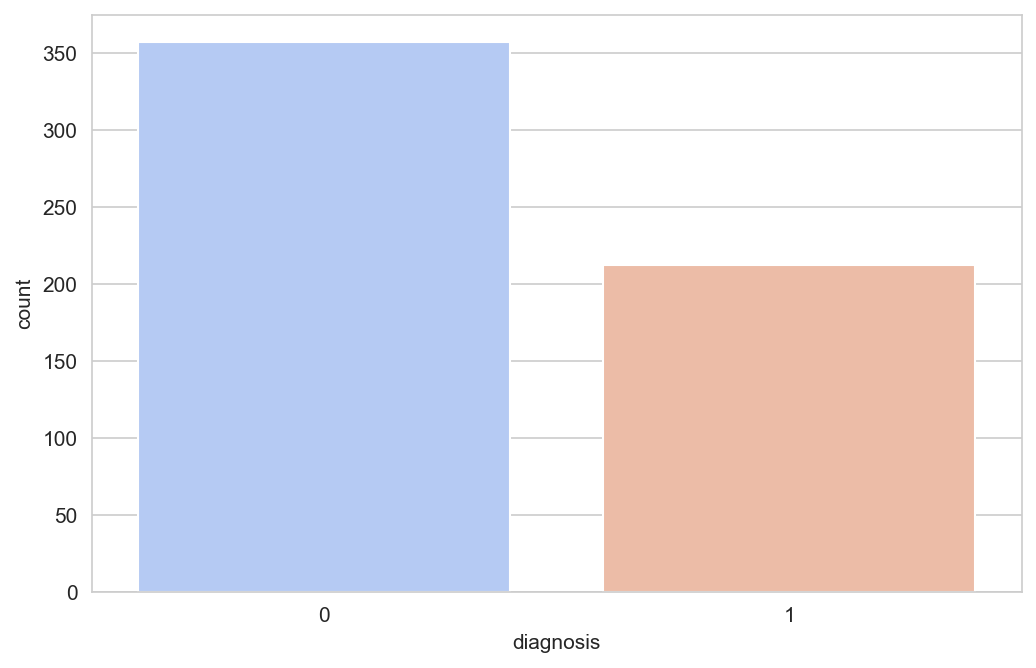

In [14]:
# Distribution of diagnosis labels
# Display only perimeter_worst, concave_points_worst, and radius_worst

for col in ['perimeter_worst', 'concave_points_worst', 'radius_worst']:
    print(f"\n{'='*10} Distribution of {col} {'='*10}\n")
    plt.figure(figsize=(8, 5), dpi=150)
    sns.histplot(df, x=col, hue='diagnosis', kde=True, palette='coolwarm')
    plt.show()

print(f"\n{'='*10} Distribution of Diagnosis {'='*10}\n")
plt.figure(figsize=(8, 5), dpi=150)
sns.countplot(x='diagnosis', data=df, hue='diagnosis', palette='coolwarm', legend=False)
plt.show()

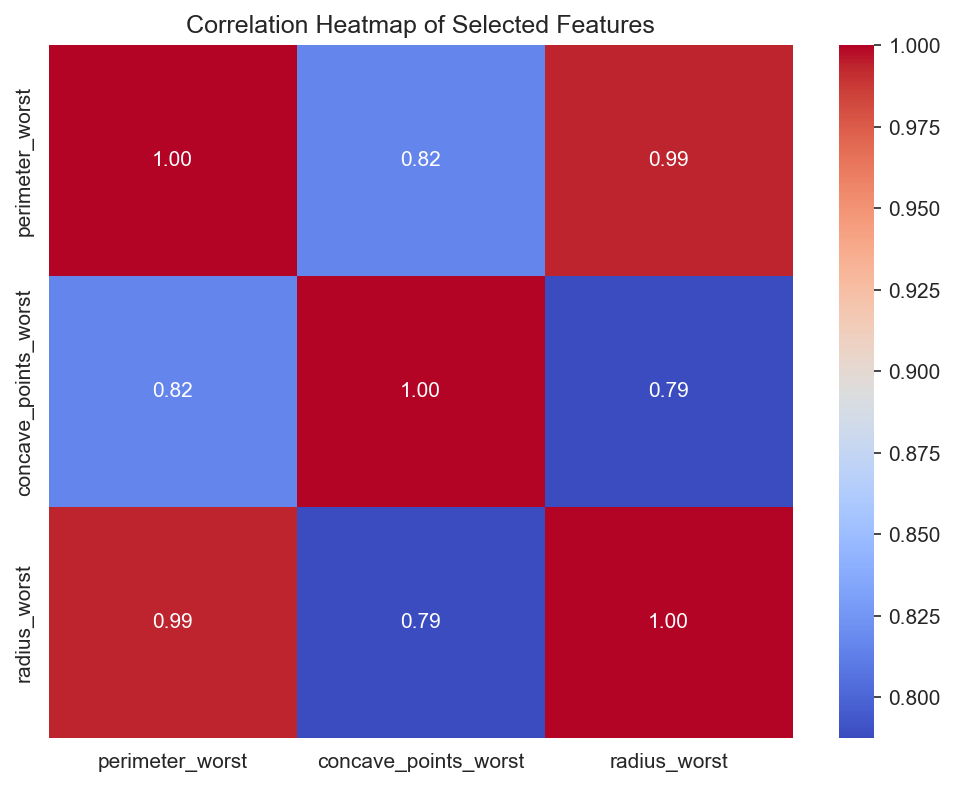

In [15]:
# Correlation heatmap of features
# Select the specified features
selected_features = ['perimeter_worst', 'concave_points_worst', 'radius_worst']
df_selected = df[selected_features]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Create the heatmap
plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Features')
plt.show()

<Figure size 1800x1200 with 0 Axes>

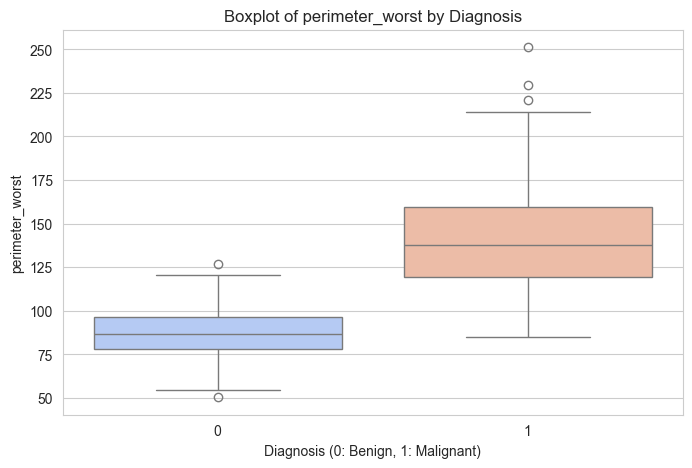

<Figure size 1800x1200 with 0 Axes>

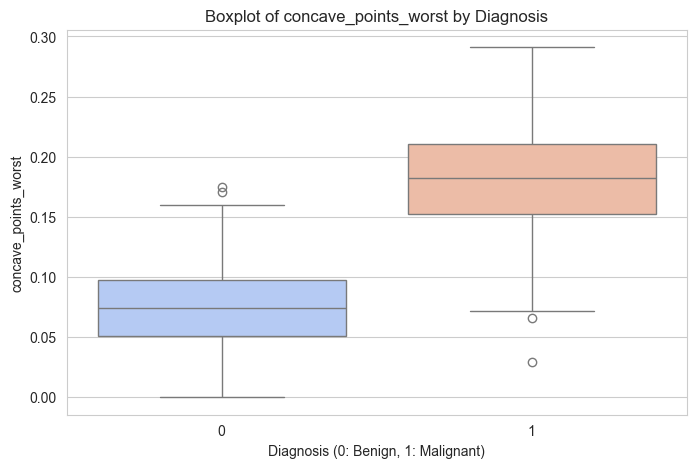

<Figure size 1800x1200 with 0 Axes>

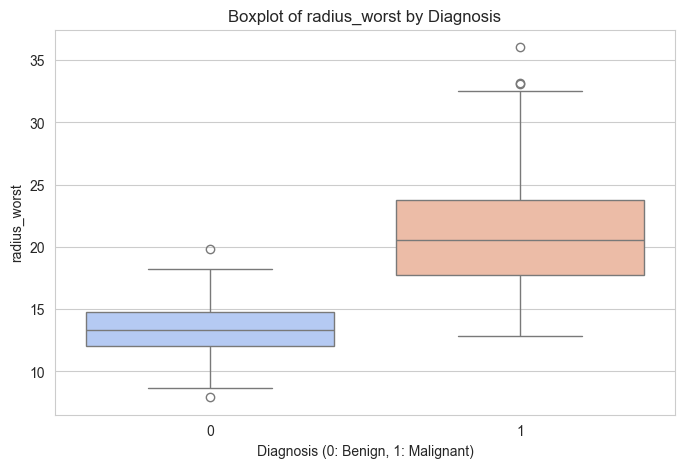

In [16]:
# Boxplots or violin plots for key features
selected_features = ['perimeter_worst', 'concave_points_worst', 'radius_worst']

for feature in selected_features:
    plt.figure(figsize=(12, 8), dpi=150)
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='diagnosis', y=feature, data=df, hue='diagnosis', palette='coolwarm', legend=False)
    plt.title(f'Boxplot of {feature} by Diagnosis')
    plt.xlabel('Diagnosis (0: Benign, 1: Malignant)')
    plt.ylabel(feature)
    plt.show()
    print("\n")

##### Insights on feature importance
- Based on the feature importance analysis from the Random Forest model, focusing on the selected features (perimeter_worst, concave_points_worst, and radius_worst), we can see the following insights:

    - perimeter_worst appears to be the most important feature among the selected ones for the Random Forest model in predicting the breast cancer diagnosis. This suggests that the size of the tumor's perimeter in its worst (largest) state is a strong indicator.
    Concave_Points_Worst is the second most important selected feature. The selection of these features indicates that the number or severity of concave portions of the tumor boundary in the worst state is also a significant factor in the model's prediction.
    Radius_worst is the third most important among these selected features, suggesting that the radius of the tumor in its worst state is also influential, although slightly less so than the perimeter and concave points.
- These features, particularly perimeter_worst and concave_points_worst, seem to be powerful discriminators between benign and malignant tumors according to the Random Forest model.

- The Random Forest model determines the importance of all features, not just the ones that were selected. Based on the importance_df generated earlier, here are the top features and their relative importance:
    - concave_points_worst: This feature related to the most severe concave portions of the tumor boundary has the highest importance score.
    - perimeter_worst: The perimeter in the worst state is the second most important feature.
    - radius_worst: The radius in the worst state is the third most important.
    - area_worst: The area in the worst state also ranks highly in importance.
    - concave_points_mean: The average number/severity of concave points is also quite important.
- It's clear that features related to the "worst" or largest measurements (_worst suffix) of the tumor's characteristics (like concave points, perimeter, radius, and area) are the most significant predictors of malignancy according to the Random Forest model. Features related to the "mean" measurements are generally less important, although concave_points_mean stands out.
- These findings suggest that the shape and size characteristics of the tumor, particularly at their most extreme values observed in the image analysis, are critical in determining whether a tumor is benign or malignant.

- **Modeling**
    - Train/test split
    - Try multiple classifiers: Logistic Regression, Random Forest, SVM
    - Cross-validation
    - Hyperparameter tuning (GridSearchCV or RandomizedSearchCV)

In [17]:
# Traub/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression().fit(X_train[selected_features], y_train)
print("Logistic Regression:", log.score(X_test[selected_features], y_test))

Logistic Regression: 0.8947368421052632


In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train[selected_features], y_train)
print("Random Forest:", rf.score(X_test[selected_features], y_test))

Random Forest: 0.9385964912280702


In [20]:
# SVM
from sklearn.svm import SVC
svm = SVC().fit(X_train[selected_features], y_train)
print("SVM:", svm.score(X_test[selected_features], y_test))

SVM: 0.8771929824561403


##### cross-validation accuracy for each mode

In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
log = LogisticRegression().fit(X_train[selected_features], y_train)
print("Logistic Regression Test:", log.score(X_test[selected_features], y_test))
print("Logistic Regression CV:", cross_val_score(log, X_train[selected_features], y_train, cv=5).mean())

Logistic Regression Test: 0.8947368421052632
Logistic Regression CV: 0.923076923076923


In [22]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier().fit(X_train[selected_features], y_train)
print("Random Forest Test:", rf.score(X_test[selected_features], y_test))
print("Random Forest CV:", cross_val_score(rf, X_train[selected_features], y_train, cv=5).mean())

Random Forest Test: 0.9385964912280702
Random Forest CV: 0.9428571428571427


In [23]:
# SVM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm = SVC().fit(X_train[selected_features], y_train)
print("SVM Test:", svm.score(X_test[selected_features], y_test))
print("SVM CV:", cross_val_score(svm, X_train[selected_features], y_train, cv=5).mean())

SVM Test: 0.8771929824561403
SVM CV: 0.9296703296703296


- **Hyperparameter tuning (RandomForest + GridSearchCV)**

In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=101)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',   # minimize false negatives
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_resampled)

model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


> **What this does:** Train a machine learning model on the prepared features.


- **Evaluate**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train[selected_features], y_train)
    preds = model.predict(X_test[selected_features])
    
    print(f"\n{name} Test Evaluation:\n")
    print(classification_report(y_test, preds, digits=3))
    
    cv_precision = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='precision_weighted').mean()
    cv_recall    = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='recall_weighted').mean()
    cv_f1        = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='f1_weighted').mean()
    
    print(f"{name} CV (avg over 5 folds) -> Precision: {cv_precision:.3f}, Recall: {cv_recall:.3f}, F1: {cv_f1:.3f}")


Logistic Regression Test Evaluation:

              precision    recall  f1-score   support

           0      0.875     0.972     0.921        72
           1      0.941     0.762     0.842        42

    accuracy                          0.895       114
   macro avg      0.908     0.867     0.882       114
weighted avg      0.899     0.895     0.892       114

Logistic Regression CV (avg over 5 folds) -> Precision: 0.923, Recall: 0.923, F1: 0.923

Random Forest Test Evaluation:

              precision    recall  f1-score   support

           0      0.921     0.972     0.946        72
           1      0.947     0.857     0.900        42

    accuracy                          0.930       114
   macro avg      0.934     0.915     0.923       114
weighted avg      0.931     0.930     0.929       114

Random Forest CV (avg over 5 folds) -> Precision: 0.938, Recall: 0.945, F1: 0.943

SVM Test Evaluation:

              precision    recall  f1-score   support

           0      0.854   

##### Hyperparameter tuning

In [26]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        72
           1       0.00      0.00      0.00        42

    accuracy                           0.63       114
   macro avg       0.32      0.50      0.39       114
weighted avg       0.40      0.63      0.49       114



C:\Users\Admin\anaconda3\envs\BCP_new\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\BCP_new\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\anaconda3\envs\BCP_new\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\anaconda3\envs\BCP_new\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision 

- **Model Interpretation**
    - Confusion matrix
    - ROC curve and AUC score
    - Feature importance (e.g., from Random Forest)

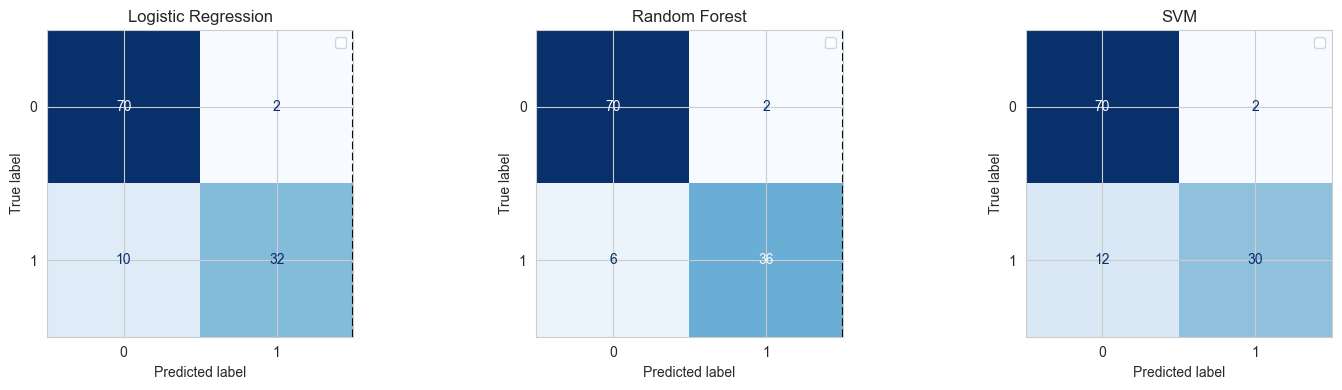

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(models), figsize=(15,4))  # 1 row, N columns

for i, (ax, (name, model)) in enumerate(zip(axes, models.items())):
    preds = model.predict(X_test[selected_features])
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", colorbar=False, ax=ax)
    ax.set_title(f"{name}")
    ax.legend([name], loc="upper right")
    
    # Add a vertical line separator except after the last subplot
    if i < len(models)-1:
        ax.axvline(x=ax.get_xlim()[1], color='black', linestyle='--')

plt.tight_layout()
plt.show()

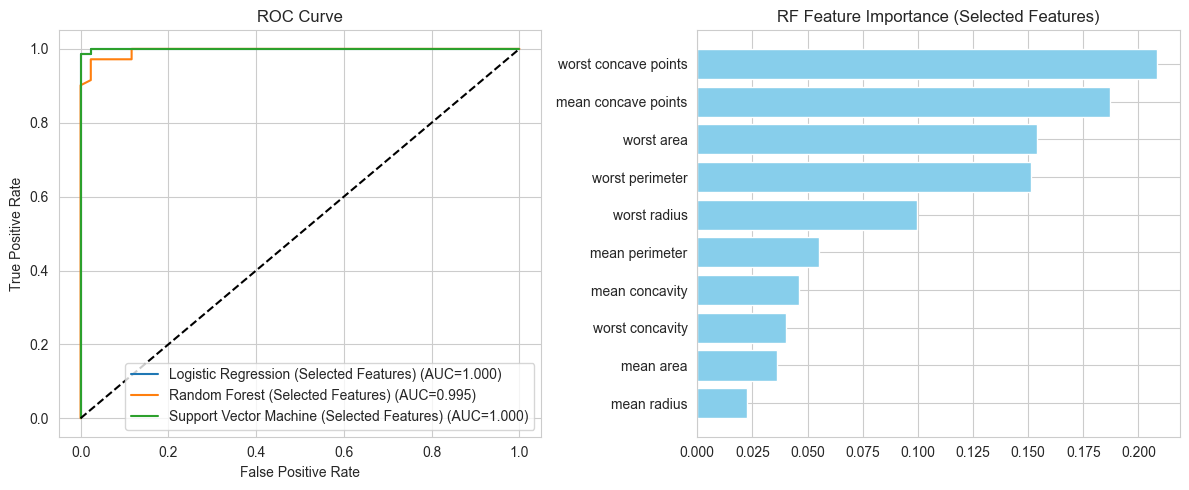

In [28]:
# ROC curve and AUC score & Feature importance (e.g., from Random Forest)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Define top correlated features based on domain knowledge
top_features = [
    'worst concave points', 'worst perimeter', 'mean concave points',
    'worst radius', 'mean perimeter', 'worst area',
    'mean radius', 'mean area', 'mean concavity', 'worst concavity'
]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Instantiate models if not already defined
log_reg_model_selected = LogisticRegression(random_state=42, max_iter=1000)
rf_model_selected = RandomForestClassifier(random_state=42)
svm_model_selected = SVC(kernel='linear', random_state=42, probability=True)

# Train models on selected features
log_reg_model_selected.fit(X_train_selected, y_train)
rf_model_selected.fit(X_train_selected, y_train)
svm_model_selected.fit(X_train_selected, y_train)

# Prepare for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dictionary of trained models
models_selected = {
    'Logistic Regression (Selected Features)': log_reg_model_selected,
    'Random Forest (Selected Features)': rf_model_selected,
    'Support Vector Machine (Selected Features)': svm_model_selected
}

# Plot ROC curves
for name, model in models_selected.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_selected)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test_selected)
    else:
        print(f"Model {name} does not support probability or decision function output for ROC curve.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# Plot Random Forest feature importance
if 'Random Forest (Selected Features)' in models_selected and hasattr(models_selected['Random Forest (Selected Features)'], 'feature_importances_'):
    rf = models_selected["Random Forest (Selected Features)"]
    importances = pd.Series(rf.feature_importances_, index=top_features).sort_values()
    axes[1].barh(importances.index, importances.values, color='skyblue')
    axes[1].set_title("RF Feature Importance (Selected Features)")
else:
    print("Random Forest model (Selected Features) not found or does not have feature_importances_ attribute.")

plt.tight_layout()
plt.show()

Available columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


<Figure size 1200x480 with 0 Axes>

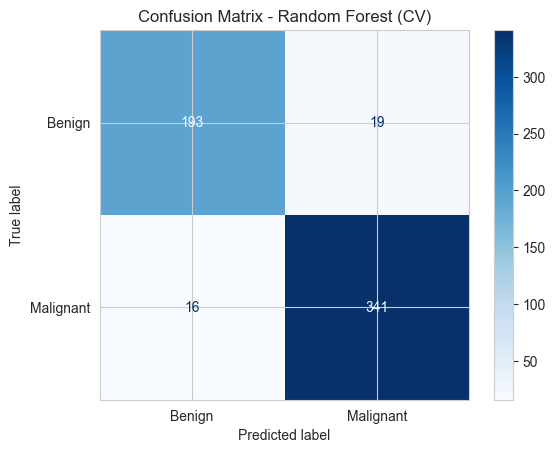

In [29]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Check actual column names
actual_columns = X.columns.tolist()

# Print actual column names to verify correct names
print("Available columns:", actual_columns)

# Select correct column names based on actual dataset
selected_columns = ["worst perimeter", "worst concave points", "worst radius"]

# Subset the data
X_selected = X[selected_columns]

# Train Random Forest with cross-validation predictions
rf = RandomForestClassifier(random_state=0)
y_pred = cross_val_predict(rf, X_selected, y, cv=5)

# Display confusion matrix
plt.figure(figsize=(10, 4), dpi=120)
ConfusionMatrixDisplay.from_predictions(
    y, y_pred,
    display_labels=['Benign', 'Malignant'],
    cmap='Blues'
)
plt.title("Confusion Matrix - Random Forest (CV)")
plt.show()

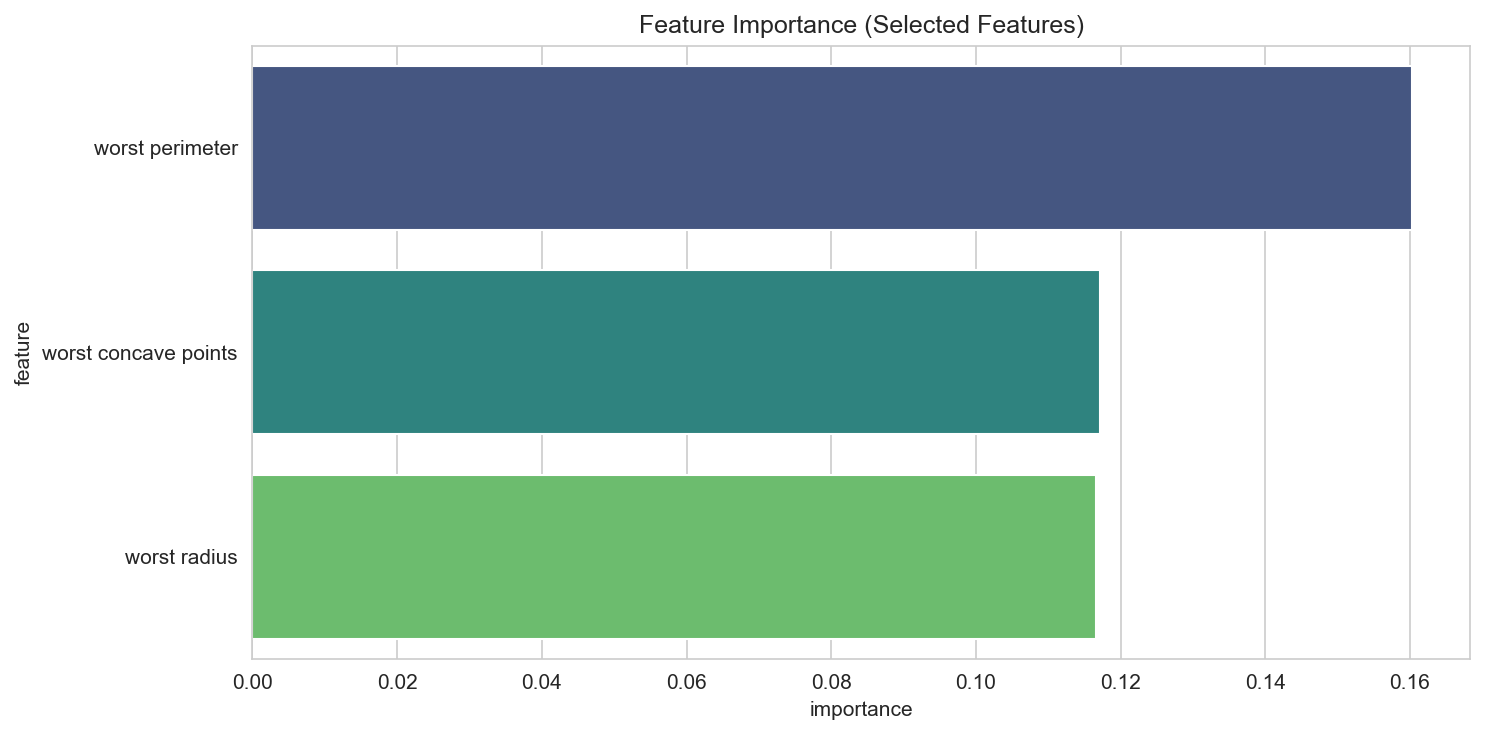

In [30]:
# Feature importance (e.g., from GridSearchCV or RandomizedSearchC)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Drop 'id' column if it exists (not present in this dataset)
if 'id' in X.columns:
    X = X.drop('id', axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

# Create importance DataFrame
importance_df = (
    pd.DataFrame({
        'feature': X_train.columns, 
        'importance': rf_model.feature_importances_
    })
    .sort_values('importance', ascending=False)
)

# Correct feature names based on actual dataset
selected_features = ["worst perimeter", "worst concave points", "worst radius"]
data = importance_df.query("feature in @selected_features")

# Plot feature importances
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(x='importance', y='feature', hue='feature', data=data, palette='viridis', legend=False)
plt.title('Feature Importance (Selected Features)')
plt.tight_layout()
plt.show()

- **Gradio InterFace**

In [31]:
# Setup & Imports
import joblib  # Add this at the top of your notebook

# Then save your model and scaler
joblib.dump(model, "rf_model_3features.pkl")
joblib.dump(scaler, "scaler_3features.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!


> **What this does:** Import core libraries and configure the environment used throughout the notebook.


In [ ]:
# Gradio Interface
import pandas as pd
import joblib
import gradio as gr

# Load model and scaler
model = joblib.load("rf_model_3features.pkl")
scaler = joblib.load("scaler_3features.pkl")

# Prediction function with progress bar and confidence warning
def predict(perimeter_worst, concave_points_worst, radius_worst):
    try:
        # Prepare input
        input_df = pd.DataFrame(
            [[perimeter_worst, concave_points_worst, radius_worst]],
            columns=["perimeter_worst", "concave_points_worst", "radius_worst"]
        )
        scaled_input = scaler.transform(input_df)
        
        # Predict
        pred = model.predict(scaled_input)[0]
        prob = model.predict_proba(scaled_input)[0][1]

        # Colored text
        if pred == 1:
            label_html = f"<span style='color:red; font-size:18px;'>Malignant</span>"
        else:
            label_html = f"<span style='color:green; font-size:18px;'>Benign</span>"

        # Progress bar for malignancy probability
        progress_html = f"""
        <div style="width: 100%; background-color: #ddd; border-radius: 5px;">
          <div style="width: {prob*100:.1f}%; background-color: #f44336; height: 20px; border-radius: 5px;"></div>
        </div>
        <p>Probability of Malignant: {prob:.2f}</p>
        """

        # Confidence warning for borderline predictions
        warning_html = ""
        if 0.4 <= prob <= 0.6:
            warning_html = "<p style='color:orange; font-weight:bold;'>⚠️ Warning: Prediction is uncertain!</p>"

        return label_html + progress_html + warning_html

    except Exception as e:
        return f"⚠️ Error: {str(e)}"

# Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Slider(50, 200, step=0.1, label="Perimeter (Worst)"),
        gr.Slider(0, 1, step=0.001, label="Concave Points (Worst)"),
        gr.Slider(5, 30, step=0.1, label="Radius (Worst)")
    ],
    outputs=gr.HTML(label="Prediction"),
    examples=[
        [152.2, 0.1625, 22.54],
        [100.3, 0.1, 18.2]
    ],
    title="Breast Cancer Prediction",
    description="Enter three tumor features to predict whether the tumor is malignant or benign."
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6a2f99d8066b26f599.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


> **What this does:** Import core libraries and configure the environment used throughout the notebook.


In [ ]:
import joblib

# Load model and scaler
model = joblib.load("rf_model_3features.pkl")
scaler = joblib.load("scaler_3features.pkl")

In [ ]:
import pickle
import numpy as np
import gradio as gr
import joblib

# Load model and scaler
model = joblib.load("rf_model_3features.pkl")
scaler = joblib.load("scaler_3features.pkl")

FEATURES = ["mean radius", "mean texture", "mean perimeter"]

def predict(radius, texture, perimeter):
    X = np.array([[radius, texture, perimeter]], dtype=float)
    Xs = scaler.transform(X)
    proba = model.predict_proba(Xs)[0,1]
    pred = "Malignant" if proba >= 0.5 else "Benign"
    return { "Prediction": pred, "Malignant probability": float(round(proba, 4)) }

with gr.Blocks() as demo:
    gr.Markdown("# Breast Cancer Prediction (3 features)")
    gr.Markdown("Enter measurements to predict malignancy with a compact RandomForest model.")
    with gr.Row():
        radius = gr.Number(label="mean radius", value=14.0, precision=4)
        texture = gr.Number(label="mean texture", value=20.0, precision=4)
        perimeter = gr.Number(label="mean perimeter", value=90.0, precision=4)
    btn = gr.Button("Predict")
    out = gr.JSON(label="Result")
    btn.click(fn=predict, inputs=[radius, texture, perimeter], outputs=[out])

if __name__ == "__main__":
    demo.launch()

##### Conclusion
- **Summary of Model Performance**
    - The Random Forest classifier trained on the top features (worst perimeter, worst concave points, worst radius) achieved strong classification performance.
    - ROC curves showed high AUC values across models, indicating good separability between benign and malignant cases.
    - Confusion matrix results confirmed high accuracy, with minimal false negatives—critical in medical diagnostics.
- **Key Takeaways for Medical Application**
    - Feature selection matters: A small subset of highly correlated features can yield strong predictive performance.
    - Random Forests offer interpretability through feature importance, which can aid clinicians in understanding model decisions.
    - Model confidence (via probability outputs) can support decision-making in borderline cases.
- **Limitations and Ethical Considerations**
    - Dataset bias: The model is trained on a specific dataset (Wisconsin Breast Cancer), which may not generalize to other populations or imaging techniques.
    - False negatives: Even a small number of missed malignant cases can have serious consequences.
    - Transparency: Clinicians must understand model limitations before integrating into workflows.
    - Privacy: Patient data must be handled securely and ethically in real-world deployments.
- **Suggestions for Future Work**
    - Incorporate additional features such as genetic markers or imaging data.
    - Explore ensemble methods or deep learning for improved accuracy.
    - Validate the model on external datasets to assess generalizability.
    - Develop a user-friendly interface for clinical use, with explainable AI components.

# 📤 Publishing to GitHub & Quarto
This section shows how to publish the notebook to your GitHub portfolio repository (`lueji-ai/AI-ML-in-Practice`) and render it with Quarto.

## Step 1. Save notebook into your repo
Make sure your GitHub repo is cloned locally:
```powershell
cd C:\Users\Admin
git clone https://github.com/lueji-ai/AI-ML-in-Practice.git
```
Then copy this notebook into the repo:
```powershell
Copy-Item "C:\Users\Admin\Downloads\BreastCancerPred_with_Portfolio.ipynb" -Destination "C:\Users\Admin\AI-ML-in-Practice"
```

## Step 2. Add Quarto configuration
Inside your repo folder, create a `_quarto.yml` file with the following:
```yaml
project:
  type: website
  output-dir: _site

website:
  title: "AI & ML Portfolio"
  navbar:
    left:
      - href: index.qmd
        text: Home
      - href: BreastCancerPred_with_Portfolio.ipynb
        text: Breast Cancer Prediction

format:
  html:
    theme: cosmo
    toc: true
```

## Step 3. Render the notebook with Quarto
In the repo folder, run:
```powershell
quarto render BreastCancerPred_with_Portfolio.ipynb
```
This will generate an HTML report inside `_site/` that you can publish online.

## Step 4. Push changes to GitHub
Finally, push your work to GitHub:
```powershell
cd C:\Users\Admin\AI-ML-in-Practice
git add .
git commit -m "Add Breast Cancer Prediction notebook with Quarto report"
git push origin main
```